## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- **Important** Don't use `snr` as feature in your classifer (that's the answer...)


### Other ideas (optional)

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [33]:
import h5py

# open file in read mode
with h5py.File('../../../dati_ligo.h5', 'r') as file:
    keys = list(file.keys())
    print("Keys in the file:")
    print(list(file.keys()))
    i = 5  # choose which event/row to print

    print(f"Event # {i}")
    for key in keys:
        print(f"{key}: {file[key][i]} \n")

Keys in the file:
['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
Event # 5
chi1x: 0.4443011011013645 

chi1y: -0.3130145910330952 

chi1z: -0.057333079484898554 

chi2x: 0.22085572377089832 

chi2y: -0.05548154598256885 

chi2z: 0.24863691324053133 

dec: -0.026682087276974187 

det: 0 

iota: 2.625059540986772 

mtot: 529.9026588479699 

psi: 1.1264916491093253 

q: 0.42260358914077123 

ra: 1.0615684259712772 

snr: 1.8936316227212333 

z: 3.2466847227573146 



In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

N = 100_000 

with h5py.File('../../../dati_ligo.h5', 'r') as file:
    data_dict = {key: file[key][:N] for key in tqdm(file.keys(), desc="data load")}
df = pd.DataFrame(data_dict)

#df_visible = df[df['snr'] >= 12]  #  threshold for visible signals

#print(f"number of visible signals: {len(df_visible)} over {N} total signals")
#print(f"percentage of visible signals: {len(df_visible) / N * 100:.2f}%")

data load: 100%|██████████| 15/15 [00:00<00:00, 90.09it/s]


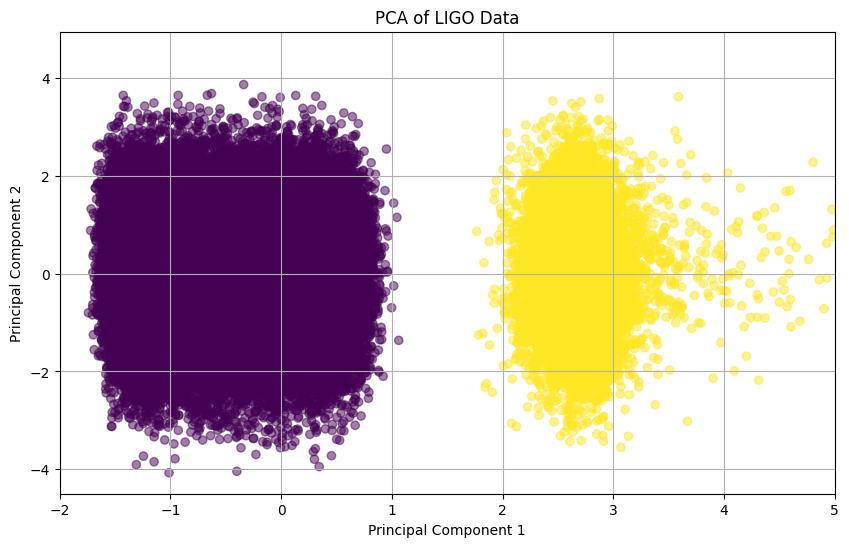

In [35]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df)
y = np.array(df['det'])

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA of LIGO Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.xlim(-2, 5)
plt.show() 


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, stratify=y, random_state=42)

In [37]:
from sklearn.metrics import roc_curve, confusion_matrix  

# RANDOM FOREST CLASSIFIER

/tmp/ipykernel_56617/603982567.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


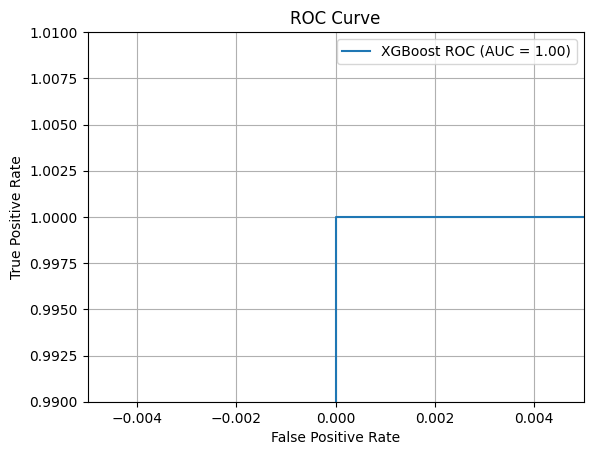

Completeness: 1.00, Contamination: 0.00


In [38]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor.fit(X_train, y_train)

y_score = ranfor.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(tpr, fpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = ranfor.predict(X_test)
C = confusion_matrix(y_test, y_pred)
C
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")


# ADABOOST

/tmp/ipykernel_56617/3335552404.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


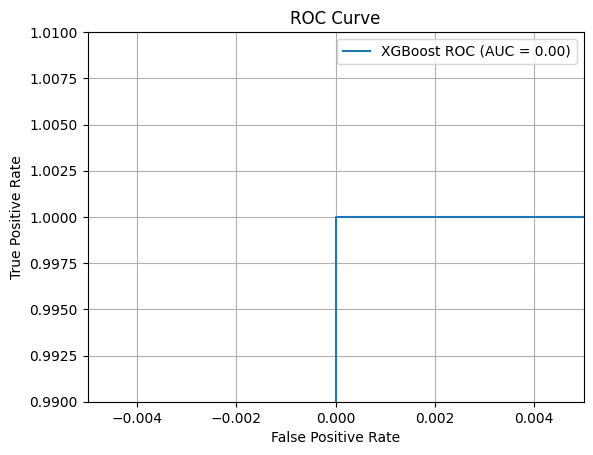

Completeness: 1.00, Contamination: 0.00


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                                       subsample=0.8, random_state=42)
gradboost.fit(X_train, y_train)

y_score = gradboost.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = gradboost.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")


# XGBoost Classifier

## What is XGBoost?
**XGBoost** (Extreme Gradient Boosting) is a highly efficient and scalable implementation of gradient boosted decision trees. It's widely used in machine learning competitions and production settings due to its speed and performance.

The core idea is to **combine the predictions of many weak learners (typically decision trees)** to form a strong predictor. At each stage, it adds a new tree that focuses on the residual errors of the previous ensemble.

---

## 🧠 How does `XGBClassifier` work?
The `XGBClassifier` trains an ensemble of decision trees in a **boosted** manner:

1. Start with an initial model (e.g., predicting the average probability).
2. Compute residuals (how wrong the current model is).
3. Fit a new tree to the residuals.
4. Add this new tree to the model with a **learning rate** factor.
5. Repeat steps 2–4 for a number of iterations (n_estimators).

It uses **gradient descent** on the loss function (e.g., log loss) to minimize prediction error over multiple boosting rounds.

---

## 🛠️ Code and Parameters

| Parameter                | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| `n_estimators=300`       | Number of boosting rounds (i.e., trees). More trees → higher capacity.      |
| `max_depth=6`            | Maximum depth of each tree. Higher depth captures more patterns but may overfit. |
| `learning_rate=0.05`     | Shrinks the contribution of each tree. Low values need more trees.          |
| `subsample=0.8`          | Fraction of training data used per tree → prevents overfitting.             |
| `colsample_bytree=0.8`   | Fraction of features used per tree → adds randomness, reduces overfitting.  |
| `random_state=42`        | Seed for reproducibility.                                                   |
| `use_label_encoder=False`| Disables old label encoder (recommended for newer versions of XGBoost).     |
| `eval_metric='logloss'`  | Metric to evaluate model performance during training. 'logloss' for classification. |

---

## ✅ When to Use XGBoost?

- High-dimensional datasets (lots of features).
- Tabular data (structured datasets).
- Problems with missing values.
- You care about model performance and speed.

---

## 📈 Tips for Use

- Tune `max_depth`, `learning_rate`, and `n_estimators` together using cross-validation.
- Use `early_stopping_rounds` with a validation set to stop when performance plateaus.
- Feature scaling is **not** required for tree-based models.


/mnt/c/Users/ASUS/Desktop/WSL_Shared/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:19:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_56617/2615659759.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


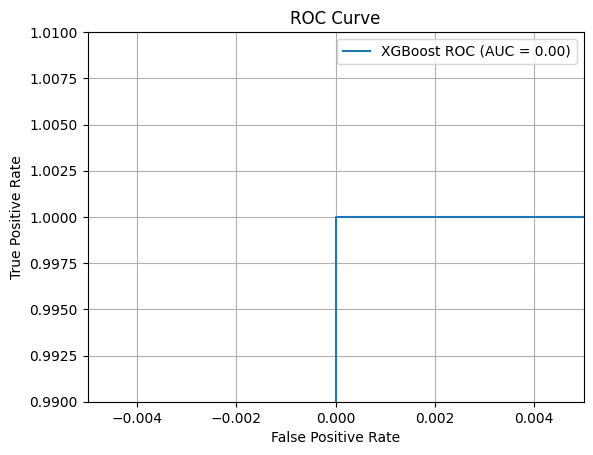

Completeness: 1.00, Contamination: 0.00


In [40]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                      subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")


# DECISION TREE CLASSIFIER

/tmp/ipykernel_56617/2463573519.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


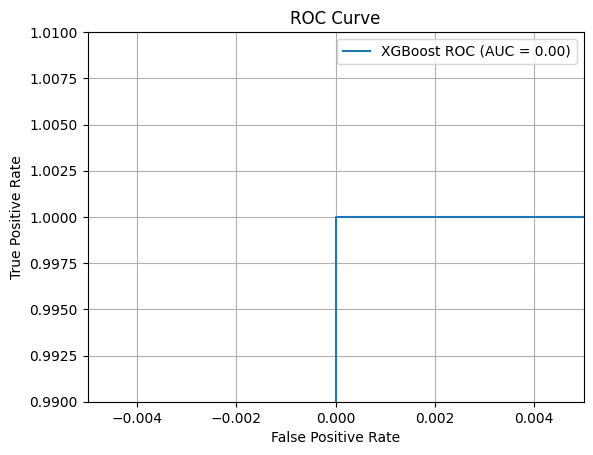

Completeness: 1.00, Contamination: 0.00


In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0, max_depth=10,criterion='entropy')
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")


# LOGISTIC REGRESSION

/mnt/c/Users/ASUS/Desktop/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_56617/4268846632.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


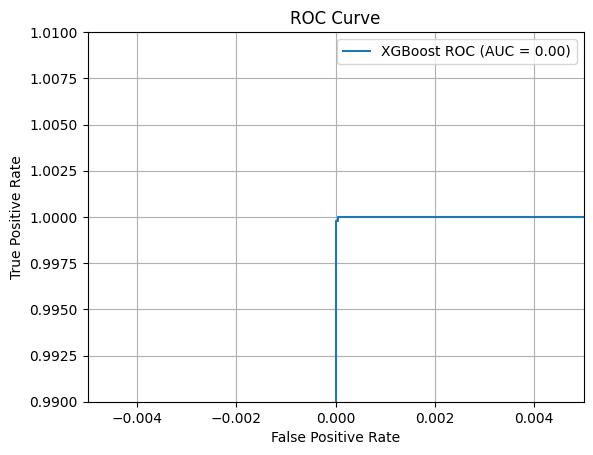

Completeness: 1.00, Contamination: 0.00


In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

# SVM

/tmp/ipykernel_56617/2996150615.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


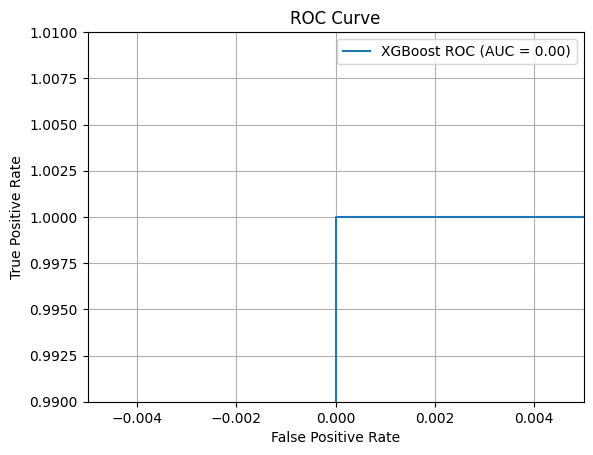

Completeness: 1.00, Contamination: 0.00


In [43]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=True, random_state=42)

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

# BAGGING

/tmp/ipykernel_56617/3428024486.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


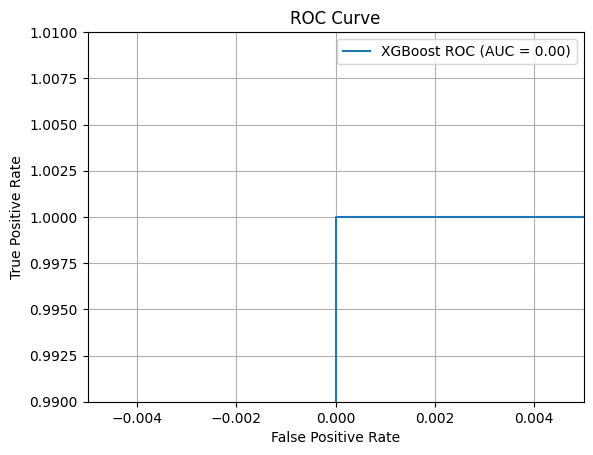

Completeness: 1.00, Contamination: 0.00


In [44]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier()

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(-0.005, 0.005)
plt.ylim(0.99, 1.01)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

# USE CROSS VALIDATION FOR THE BEST